In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy.integrate import solve_ivp
from scipy.constants import pi
import scienceplots
import winsound
plt.style.use(['grid', 'science', 'notebook'])

In [2]:
#Constants
g_cm3_to_mev4 = 4.24742944e-6
dynes_cm2_to_mev4 = 4.56e-27
neutron_drip_density = 4e11 #cgs
G = 6.6743e-11 #m3/kgs2
Gmev = 6.8034e-45
MeV_to_kg = 1.8e-30
Msun = 1.989e30 #kg
Msun_MeV = Msun/MeV_to_kg

In [3]:
#BPS EoS (before Pcrit)
bps_datapack = np.genfromtxt('BPS.dat', dtype=float, skip_header=1)
bps_enden_arr = bps_datapack.T[0]*g_cm3_to_mev4
bps_p_arr = bps_datapack.T[1]*dynes_cm2_to_mev4
min_pressure = min(bps_p_arr)
max_pressure = 1e11
bps_eos = interp1d(bps_p_arr, bps_enden_arr, 'cubic', fill_value='extrapolate')
bps_p_f = interp1d(bps_enden_arr,bps_p_arr,'cubic',fill_value='extrapolate')

In [4]:
Pcrit = bps_p_f(neutron_drip_density*g_cm3_to_mev4)

In [5]:
#EoS: kP+4B (after Pcrit)
k = 3 #dimensionless
B = 145**4 #MeV4
dp = 100
def kPand4B(P):
    return (k*P + 4*B)

In [6]:
#Final EoS
def eos(p):
    e = 1/2*(1-np.tanh((p - Pcrit)/dp))*bps_eos(p) + 1/2*(1+np.tanh((p - Pcrit)/dp))*kPand4B(p)
    return e

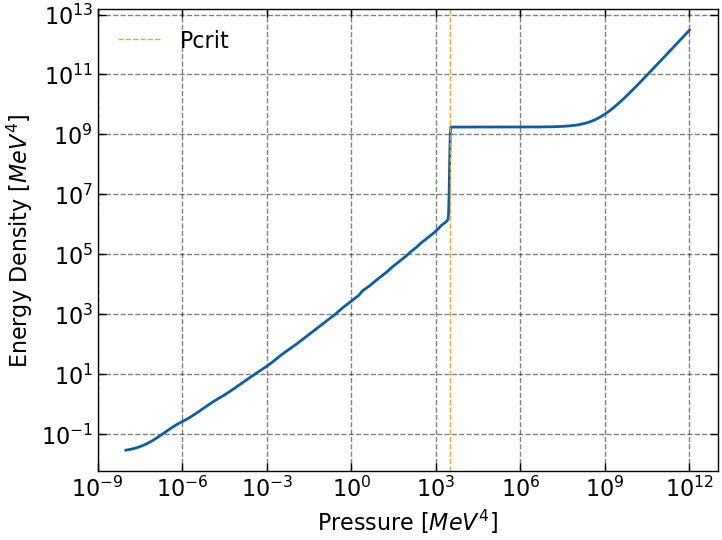

In [7]:
pressures = np.logspace(-8,12,1000)
plt.plot(pressures, eos(pressures))
plt.xscale('log')
plt.yscale('log')
plt.axvline(Pcrit, color='orange', linestyle='--', label='Pcrit', linewidth='1')
plt.legend()
plt.xlabel('Pressure [$MeV^4$]')
plt.ylabel('Energy Density [$MeV^4$]')
plt.show()

In [8]:
dr = 0.005
radii = np.arange(dr, 1e5 + dr, dr)
rad = radii*1e15/0.197

Pc = 7e6 #mev4
mc = (4/3)*pi*rad[0]**3*eos(Pc)
y0 = [Pc,mc]

def dSdr(r, S):
    P, m = S
    dpdr = -Gmev/r*(P + eos(P))*(m+4*pi*r**3*P)/(r-2*Gmev*m)
    dmdr = 4*pi*r**2*eos(P)
    return [dpdr, dmdr]

sol = solve_ivp(dSdr, t_span=(min(rad),max(rad)), y0=y0, t_eval=rad, rtol=1e-12)
Parr, marr = sol['y']

In [9]:
r=[]
m=[]
p=[]
for i,em in enumerate(Parr):
    if em<0:
        break
    r.append(rad[i])
    m.append(marr[i])
    p.append(Parr[i])
M = max(m)
R = max(r)
pf = interp1d(r,p,'cubic')
mf = interp1d(r,m,'cubic')

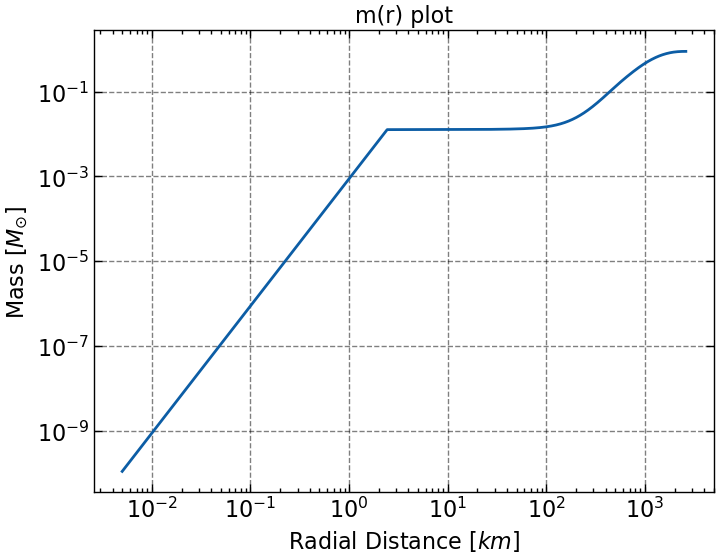

In [10]:
plt.plot(np.array(r)/(1e15/0.197),np.array(m)/Msun_MeV)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radial Distance [$km$]')
plt.ylabel('Mass [$M_{\odot}$]')
plt.title('m(r) plot')
plt.show()

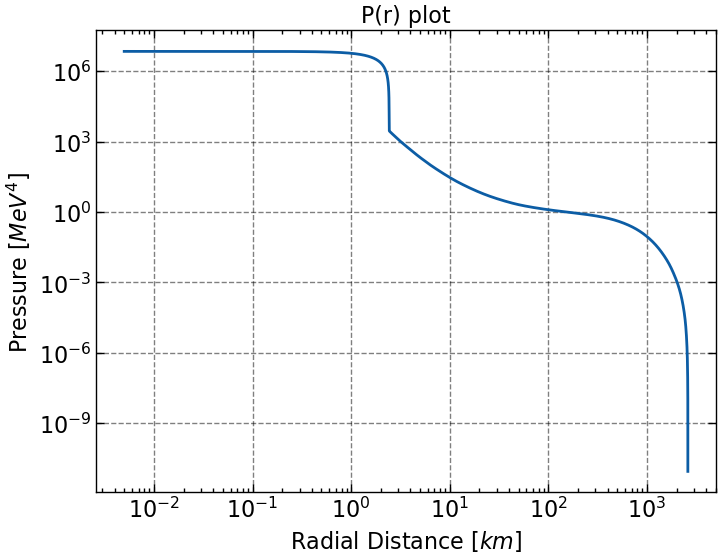

In [11]:
plt.plot(np.array(r)/(1e15/0.197),p)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Radial Distance [$km$]')
plt.ylabel('Pressure [$MeV^4$]')
plt.title('P(r) plot')
plt.show()

In [12]:
def l(r):
    return -(1/2)*np.log(1-2*Gmev*mf(r)/r)

In [13]:
def integral(P):
    return 2/(P + eos(P))

vR = (1/2)*np.log(1-2*Gmev*M/R)
v_arr = []
rad_less = np.linspace(min(rad), R, 5000)
for i,em in enumerate(rad_less):
    res, err = quad(integral, 0, pf(em))
    v_arr.append(vR - res)

v = interp1d(rad_less, v_arr, 'cubic')

In [14]:
(v_arr[-1] - vR)/vR * 100 #error of vR

0.0001390806664389091

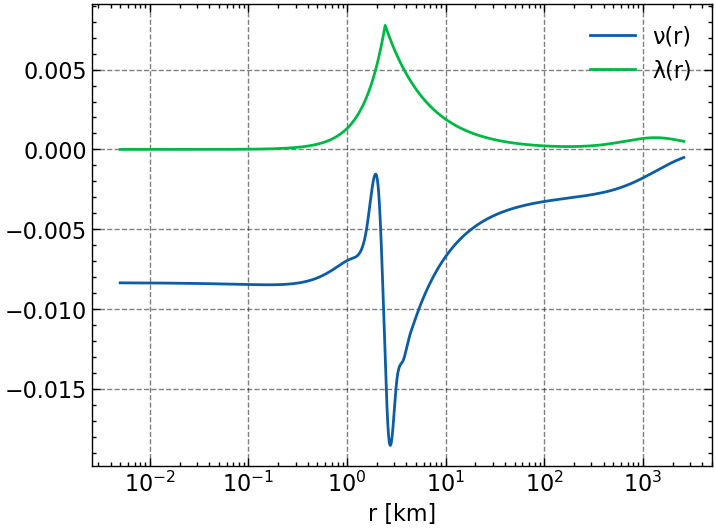

In [15]:
plt.plot(np.array(r)/(1e15/0.197), v(r), label='ν(r)')
plt.plot(np.array(r)/(1e15/0.197),l(r), label='λ(r)')
plt.xlabel('r [km]')
plt.xscale('log')
plt.legend()
plt.show()

In [16]:
dpde = np.gradient(pf(r), eos(pf(r)))
dpdef = interp1d(r,dpde, 'cubic')
def gamma(r):
    press = pf(r)
    return (eos(press) + press)/press * dpdef(r)
def W(r):
    press = pf(r)
    return (eos(press) + press) * np.exp(3*l(r) + v(r))/r**2
def H(r):
    press = pf(r)
    return gamma(r)*press * np.exp(l(r) + 3*v(r))/r**2
def Q(r):
    press = pf(r)
    dvdr = Gmev/r * ( mf(r) + 4*pi*r**3*press)/(r - 2*Gmev*mf(r))
    return (eos(press) + press)* np.exp(l(r) + 3*v(r))/r**2 * (dvdr**2 + 4*dvdr/r - 8*pi*Gmev*np.exp(2*l(r))*press)

Wo, Ho, Qo = W(min(r)), H(min(r)), Q(min(r))

In [17]:
x = np.linspace(0.001, 1, 10000)
def Wx(x):
    return W(x*R)/Wo
def Hx(x):
    return H(x*R)/Ho
def Qx(x):
    return Q(x*R)/Qo

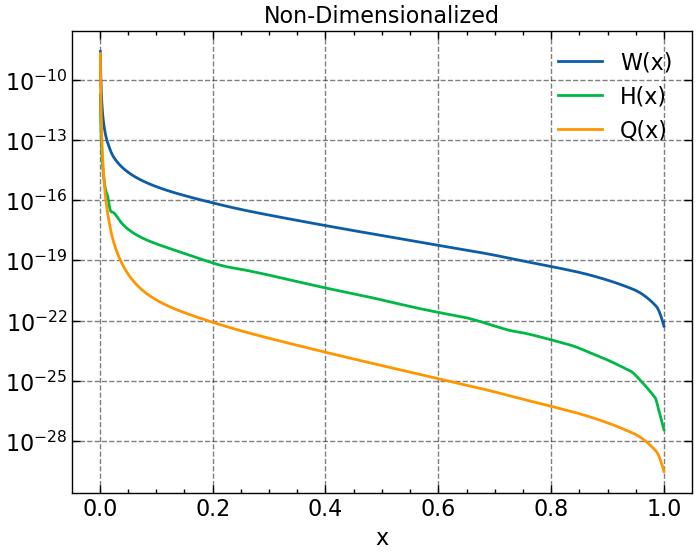

In [18]:
plt.plot(x, Wx(x),label='W(x)')
plt.plot(x, Hx(x),label='H(x)')
plt.plot(x, Qx(x),label='Q(x)')
plt.yscale('log')
plt.legend()
plt.xlabel('x')
plt.title('Non-Dimensionalized')
plt.show()

In [19]:
def dydx(x, y,eigen):
    z, h = y
    dzdx = 3*R*h/Hx(x)
    dhdx = -(R*Qo/(3*Ho)*Qx(x) + R*Wo/(3*Ho)*eigen* Wx(x))*z
    return [dzdx, dhdx]

In [20]:
U0 = 1/(3*Ho)
z0 = 1
h0 = 1
init = [z0,h0]

In [21]:
f = 0.194337 # CHANGING THIS VALUE.
omega = 2*pi*f* 6.6e-22
eigen = +omega**2 # CHANGING THIS SIGN.

sollution = solve_ivp(dydx, args=(eigen,),y0=init, t_span = (min(x), max(x)), t_eval=x)
z, h = sollution['y']

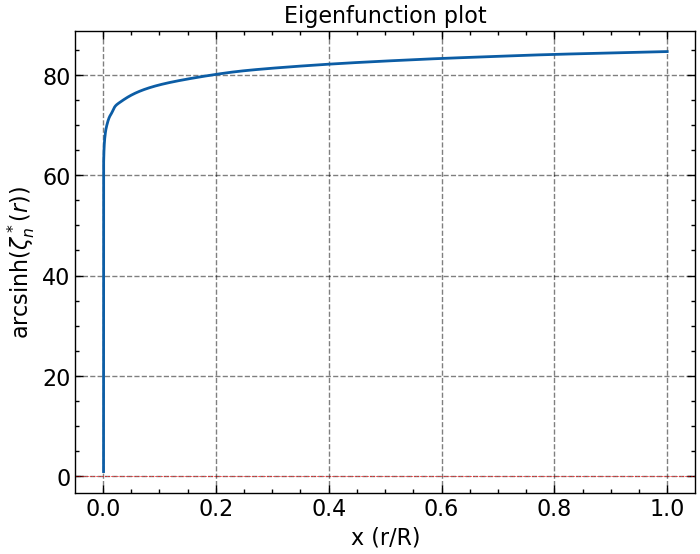

In [22]:
plt.plot(x,np.arcsinh(z))
plt.axhline(0, linestyle='--', linewidth=0.4, color='red')
plt.title('Eigenfunction plot')
plt.xlabel('x (r/R)')
plt.ylabel('arcsinh($\zeta_n^*(r)$)')
plt.show()

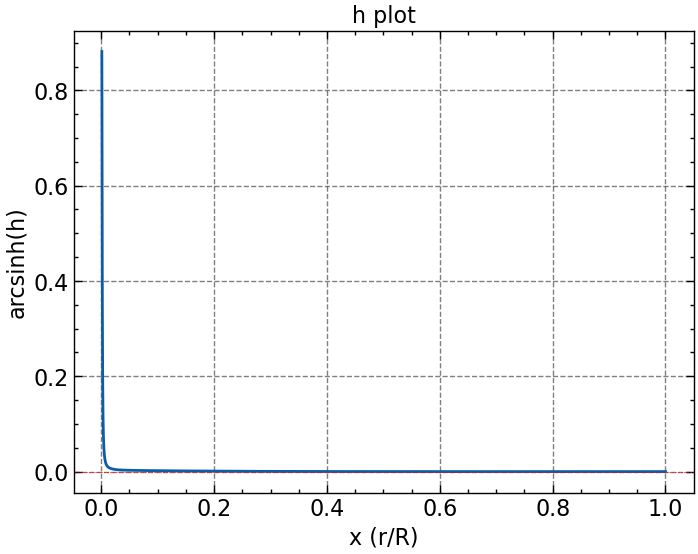

In [23]:
plt.plot(x,np.arcsinh(h))
plt.axhline(0, linestyle='--', linewidth=0.4, color='red')
plt.title('h plot')
plt.xlabel('x (r/R)')
plt.ylabel('arcsinh(h)')
plt.show()

In [24]:
counts=0
roots=[]
for i in range(1,len(h)):
    if h[i]*h[i-1]<0:
        counts+=1
        roots.append(x[i])
print(counts)
print(roots)

1
[1.0]
